In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Han_Toss/중간 프로젝트/재무건강_데이터.csv', encoding = 'CP949')

In [ ]:
df['월지출비'] = ((df['지출_소비지출비'] + df['지출_비소비지출(보완)'])/12).round(2)
df['자산대비부채비율'] = (df['부채']/df['자산']).round(2)
df['자산대비저축금액'] = (df['자산_금융자산_저축금액']/df['자산']).round(2)
df['자산대비주식채권펀드'] = (df['자산_금융자산_저축_적립예치식저축_주식채권펀드금액']/df['자산']).round(2)

In [ ]:
df = df.replace({'G1': 0, 'G2': 1, 'G3': 2, 'G4':3, 'G5':4, 'G6':5 })
df.head()

,가구주_성별코드,가구원수,가구주연령_10세단위코드,가구주_종사상지위(보도용),가구주_혼인상태코드,자산,자산_금융자산_저축금액,자산_금융자산_저축_적립예치식저축_주식채권펀드금액,부채,경상소득(보완),...,지출_비소비지출(보완),지출_비소비지출_공적연금사회보험료(보완),원리금연체여부,가구주_은퇴여부,가구주_미은퇴_노후준비상황코드,가구주_은퇴_적정생활비충당여부,월지출비,자산대비부채비율,자산대비저축금액,자산대비주식채권펀드
0,2,1,4,1,3,5700,700,0,0,1655,...,121,0,NaN,1,5.0,NaN,108.00,0.00,0.12,0.00
1,1,2,4,0,2,13720,3220,0,0,2995,...,425,369,NaN,1,3.0,NaN,267.92,0.00,0.23,0.00
2,2,1,1,0,1,1410,410,0,0,3001,...,109,38,NaN,1,5.0,NaN,109.92,0.00,0.29,0.00
3,2,1,4,1,3,16800,10300,0,300,1871,...,27,0,NaN,1,3.0,NaN,104.08,0.02,0.61,0.00
4,1,1,3,0,1,17000,11000,10000,9000,3603,...,614,302,2.0,1,3.0,NaN,173.33,0.53,0.65,0.59


## 기초체력, 면역력, 건강지속력 각 영역별 조건에 맞는 결과 행에 할당하기

In [ ]:
df.reset_index(drop=True, inplace=True)

# 각 행의 결과를 저장할 열 추가
df['stamina_result'] = ''
df['immunity_result'] = ''
df['sustainability_result'] = ''


for i in range(len(df)):
  # 현재 행의 조건을 저장
  sex = df.loc[i, '가구주_성별코드']
  fam_num = df.loc[i, '가구원수']
  fam_age = df.loc[i, '가구주연령_10세단위코드']
  marital = df.loc[i, '가구주_혼인상태코드']

    # i행과 동일한 조건을 가진 행들만 추출
  same_condition_df = df[
    (df['가구주_성별코드'] == sex) &
    (df['가구원수'] == fam_num) &
    (df['가구주연령_10세단위코드'] == fam_age) &
    (df['가구주_혼인상태코드'] == marital)
  ]

  stamina = []
  immunity = []
  sustainability = []

  # 소득수준
  if df.loc[i, '경상소득(보완)']*12 < same_condition_df['경상소득(보완)'].mean()*12: stamina.append('F')
  else:stamina.append('T')

  # 소비수준
  if df.loc[i, '월지출비']*12 < df.loc[i, '경상소득(보완)']: stamina.append('F')
  else: stamina.append('T')

  # 소득안전성(0: 상용근로자, 1:임시 일용 근로자, 2: 자영업자, 3: 무직 등)
  if df.loc[i, '가구주_종사상지위(보도용)'] == 0: stamina.append('T')
  else: stamina.append('F')

  # 납부기한관리 (1:있음, 2:없음)
  if df.loc[i, '원리금연체여부'] ==1 : stamina.append('F')
  else: stamina.append('T')

  # 보험여부
  if df.loc[i, '지출_비소비지출_공적연금사회보험료(보완)']==0 or df.loc[i, '지출_비소비지출_공적연금사회보험료(보완)']/df.loc[i, '경상소득(보완)']>=0.2: immunity.append('F')
  else: immunity.append('T')

  # 은퇴에 따른 질문(1: 미은퇴, 2: 은퇴)
  # Q1 : 은퇴를 하셨나요? (1: 미은퇴, 2: 은퇴)
  # Q1-1 : 은퇴를 하지 않으셨다면 노후 준비를 잘 하고 계신가요?
  # A1-1: 아주 잘 되었있다. 2: 잘 되어 있다. 3: 보통이다. 4: 잘 되어 있지 않다 5: 전혀 되어있지않다
  # Q1-2 : 은퇴를 하셨다면 생활비가 적절한 수준이가요?
  # A1-2 : 1: 충분히 여유 있다. 2: 여유 있다 3: 보통이다 4: 부족하다 5: 매우 부족하다
  if df.loc[i, '가구주_은퇴여부'] == 1:
    if df.loc[i, '가구주_미은퇴_노후준비상황코드'] >=4: immunity.append('F')
    else: immunity.append('T')
  else:
    if df.loc[i, '가구주_은퇴_적정생활비충당여부'] >=4: immunity.append('F')
    else: immunity.append('T')

  # 부채
  if (df.loc[i, '자산']/ df.loc[i, '부채']).round(2) >= 0.4: immunity.append('F')
  else: immunity.append('T')

  # 저축 성향
  if df.loc[i, '자산대비저축금액']<0.1: sustainability.append('F')
  else: sustainability.append('T')

  # 투자 성향
  if df.loc[i, '자산대비주식채권펀드'] < 0.14: sustainability.append('F')
  else: sustainability.append('T')



  # 각 행의 결과를 데이터프레임에 저장
  df.at[i, 'stamina_result'] = stamina
  df.at[i, 'immunity_result'] = immunity
  df.at[i, 'sustainability_result'] = sustainability

<ipython-input-6-f77d71430b2e>:62: RuntimeWarning: divide by zero encountered in scalar divide
  if (df.loc[i, '자산']/ df.loc[i, '부채']).round(2) >= 0.4: immunity.append('F')
<ipython-input-6-f77d71430b2e>:62: RuntimeWarning: invalid value encountered in scalar divide
  if (df.loc[i, '자산']/ df.loc[i, '부채']).round(2) >= 0.4: immunity.append('F')
<ipython-input-6-f77d71430b2e>:45: RuntimeWarning: divide by zero encountered in scalar divide
  if df.loc[i, '지출_비소비지출_공적연금사회보험료(보완)']==0 or df.loc[i, '지출_비소비지출_공적연금사회보험료(보완)']/df.loc[i, '경상소득(보완)']>=0.2: immunity.append('F')


In [ ]:
df[['stamina_result', 'immunity_result', 'sustainability_result']]

,stamina_result,immunity_result,sustainability_result
0,"[T, F, F, T]","[F, F, F]","[T, F]"
1,"[F, T, T, T]","[T, T, F]","[T, F]"
2,"[F, F, T, T]","[T, F, F]","[T, F]"
3,"[T, F, F, T]","[F, T, F]","[T, F]"
4,"[T, F, T, T]","[T, T, F]","[T, T]"
...,...,...,...
18089,"[F, F, F, T]","[T, F, F]","[T, F]"
18090,"[F, F, T, T]","[T, T, F]","[T, T]"
18091,"[T, F, T, T]","[T, T, F]","[T, F]"
18092,"[T, F, T, T]","[T, T, F]","[T, F]"


# 최종 결과 코드
다음의 5가지 재무건강에 맞도록 target 값 생성
- 재무건강 우수:0
- 재무건강 양호:1
- 재무건강 보통:2
- 재무건강 허약:3
- 재무건강 위급:4

In [ ]:
# T가 과반수 이상인지 확인하고 결과를 'T' 또는 'F'로 바꾸는 함수
def get_majority_result(result_list):
    if result_list.count('T') > len(result_list) / 2:
        return 'T'
    else:
        return 'F'

# 각 행에 대해 결과를 업데이트
for i in range(len(df)):
    df.at[i, 'stamina_result'] = get_majority_result(df.at[i, 'stamina_result'])
    df.at[i, 'immunity_result'] = get_majority_result(df.at[i, 'immunity_result'])
    df.at[i, 'sustainability_result'] = get_majority_result(df.at[i, 'sustainability_result'])

# 결과 확인
print(df[['stamina_result', 'immunity_result', 'sustainability_result']])

      stamina_result immunity_result sustainability_result
0                  F               F                     F
1                  T               T                     F
2                  F               F                     F
3                  F               F                     F
4                  T               T                     T
...              ...             ...                   ...
18089              F               F                     F
18090              F               T                     T
18091              T               T                     F
18092              T               T                     F
18093              F               T                     F

[18094 rows x 3 columns]


In [ ]:
# 재무건강 우량: 0, 재무건강 양호:1, 재무건강 기초:2, 재무건강 허약:3, 재무건강 위급:4

def make_result(stamina_result, immunity_result, sustainability_result):
  if stamina_result == 'T' and immunity_result == 'T' and sustainability_result == 'T': result = 0
  elif stamina_result == 'T' and immunity_result == 'T' and sustainability_result == 'F': result = 1
  elif stamina_result == 'T' and immunity_result == 'F' and sustainability_result == 'T': result = 1
  elif stamina_result == 'T' and immunity_result == 'F' and sustainability_result == 'F': result = 2
  elif stamina_result == 'F' and immunity_result == 'T' and sustainability_result == 'T': result = 3
  elif stamina_result == 'F' and immunity_result == 'T' and sustainability_result == 'F': result = 3
  elif stamina_result == 'F' and immunity_result == 'F' and sustainability_result == 'T': result = 3
  elif stamina_result == 'F' and immunity_result == 'F' and sustainability_result == 'F': result = 4

  return result


df['target'] = None
for i in range(len(df)):
  df.loc[i, 'target'] = make_result(df.loc[i, 'stamina_result'], df.loc[i, 'immunity_result'], df.loc[i, 'sustainability_result'])

In [ ]:
df['target']

,target
0,4
1,1
2,4
3,4
4,0
...,...
18089,4
18090,3
18091,1
18092,1


In [ ]:
df

,가구주_성별코드,가구원수,가구주연령_10세단위코드,가구주_종사상지위(보도용),가구주_혼인상태코드,자산,자산_금융자산_저축금액,자산_금융자산_저축_적립예치식저축_주식채권펀드금액,부채,경상소득(보완),...,가구주_미은퇴_노후준비상황코드,가구주_은퇴_적정생활비충당여부,월지출비,자산대비부채비율,자산대비저축금액,자산대비주식채권펀드,stamina_result,immunity_result,sustainability_result,target
0,2,1,4,1,3,5700,700,0,0,1655,...,5.0,NaN,108.00,0.00,0.12,0.00,F,F,F,4
1,1,2,4,0,2,13720,3220,0,0,2995,...,3.0,NaN,267.92,0.00,0.23,0.00,T,T,F,1
2,2,1,1,0,1,1410,410,0,0,3001,...,5.0,NaN,109.92,0.00,0.29,0.00,F,F,F,4
3,2,1,4,1,3,16800,10300,0,300,1871,...,3.0,NaN,104.08,0.02,0.61,0.00,F,F,F,4
4,1,1,3,0,1,17000,11000,10000,9000,3603,...,3.0,NaN,173.33,0.53,0.65,0.59,T,T,T,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18089,1,3,2,2,2,5350,2550,0,0,4868,...,5.0,NaN,293.92,0.00,0.48,0.00,F,F,F,4
18090,1,4,2,0,2,77907,26044,12964,0,8725,...,3.0,NaN,533.67,0.00,0.33,0.17,F,T,T,3
18091,1,3,3,0,2,108881,17881,0,23020,18935,...,3.0,NaN,1136.00,0.21,0.16,0.00,T,T,F,1
18092,1,4,3,0,2,164150,32460,800,0,14356,...,2.0,NaN,575.42,0.00,0.20,0.00,T,T,F,1


In [ ]:
df = df.drop(['stamina_result', 'immunity_result', 'sustainability_result'], axis=1)

In [ ]:
df.head()

,가구주_성별코드,가구원수,가구주연령_10세단위코드,가구주_종사상지위(보도용),가구주_혼인상태코드,자산,자산_금융자산_저축금액,자산_금융자산_저축_적립예치식저축_주식채권펀드금액,부채,경상소득(보완),...,지출_비소비지출_공적연금사회보험료(보완),원리금연체여부,가구주_은퇴여부,가구주_미은퇴_노후준비상황코드,가구주_은퇴_적정생활비충당여부,월지출비,자산대비부채비율,자산대비저축금액,자산대비주식채권펀드,target
0,2,1,4,1,3,5700,700,0,0,1655,...,0,NaN,1,5.0,NaN,108.00,0.00,0.12,0.00,4
1,1,2,4,0,2,13720,3220,0,0,2995,...,369,NaN,1,3.0,NaN,267.92,0.00,0.23,0.00,1
2,2,1,1,0,1,1410,410,0,0,3001,...,38,NaN,1,5.0,NaN,109.92,0.00,0.29,0.00,4
3,2,1,4,1,3,16800,10300,0,300,1871,...,0,NaN,1,3.0,NaN,104.08,0.02,0.61,0.00,4
4,1,1,3,0,1,17000,11000,10000,9000,3603,...,302,2.0,1,3.0,NaN,173.33,0.53,0.65,0.59,0


## 위의 결과를 기반으로 RandomForestClassifier 실행

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 필요한 열 선택
target = df['target'].astype(int)
features = df.drop(columns=['target'])  # target 열을 제외한 나머지

# 범주형 변수 원-핫 인코딩
categorical_columns = ['가구주_성별코드', '가구주연령_10세단위코드', '가구주_종사상지위(보도용)', '가구주_혼인상태코드', '원리금연체여부', '가구주_은퇴여부', '가구주_미은퇴_노후준비상황코드', '가구주_은퇴_적정생활비충당여부']
features = pd.get_dummies(features, columns=categorical_columns)

# 결측치가 있는지 확인하고, 결측치를 처리합니다.
features.fillna(features.mean(), inplace=True)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# 학습 데이터에 대한 예측 및 정확도 계산
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



              precision    recall  f1-score   support

           0       0.95      0.91      0.93        81
           1       0.86      0.88      0.87       683
           2       0.84      0.72      0.77       426
           3       0.93      0.93      0.93      1450
           4       0.96      0.97      0.97      2789

    accuracy                           0.93      5429
   macro avg       0.91      0.88      0.89      5429
weighted avg       0.93      0.93      0.93      5429

Test Accuracy: 0.9298213298950083
Training Accuracy: 1.0000
Test Accuracy: 0.9298


### Confusion_Matrix 그래프 출력

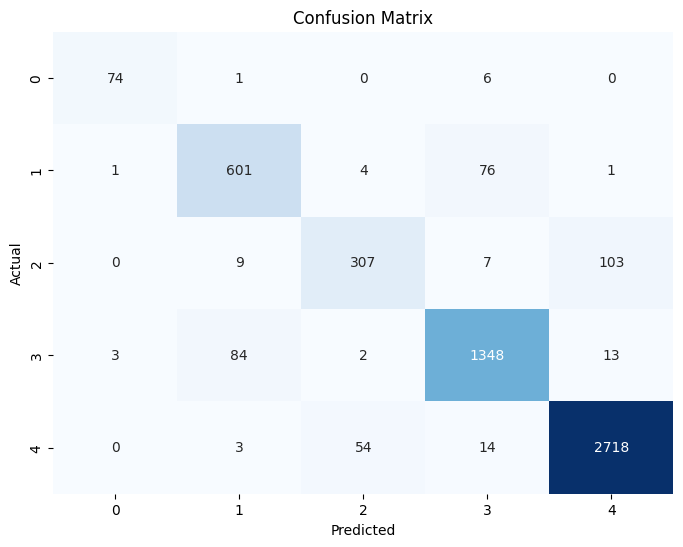

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 혼동 행렬(Confusion Matrix) 시각화
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### ROC_Curve 출력

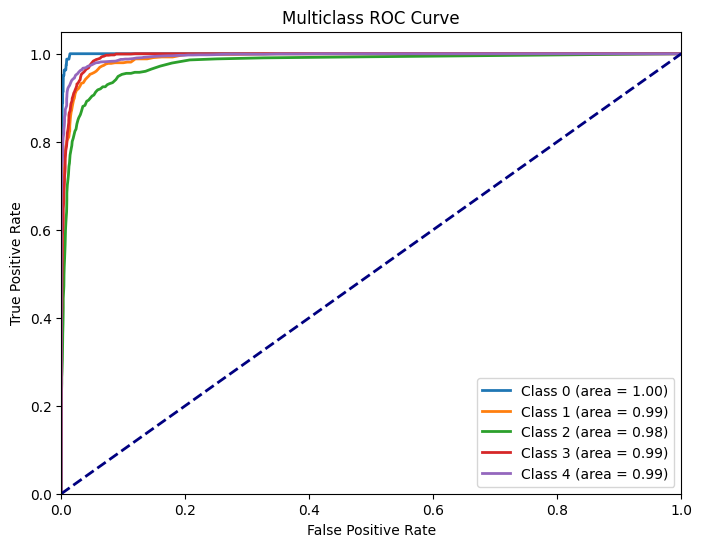

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay

# 다중 클래스 레이블을 이진화
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# RandomForestClassifier을 One-vs-Rest로 감싸기
model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, label_binarize(y_train, classes=np.unique(y_train)))

# 예측 확률 얻기
y_score = model.predict_proba(X_test)

# 각 클래스별로 ROC Curve를 그리기
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()
